In [2]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import bellman_ford
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import re
import networkx as nx
from openpyxl import load_workbook
import random

In [309]:
# importing data
data = pd.read_excel("data/8.18.21.xlsx")
date = str(data["Date"][0].month) + "/" + str(data["Date"][0].day) + "/" + str(data["Date"][0].year)

tokens = []
for elt in data['Pool Tokens']:
    res = re.split(' / ', elt)
    if res[0] not in tokens:
        tokens.append(res[0])
    if res[1] not in tokens:
        tokens.append(res[1])
        
l = len(tokens)

In [264]:
# constructing graph based on Uniswap market data
def construct_graph(data):
    G = nx.DiGraph()
    for elt in tokens:
        G.add_node(elt)
    for index, row in data[['Pool Tokens', 'Volume Token 0 (Excel)', 'Volume Token 1 (Excel)', 'Volume USD (Excel)', 'Fees USD (Excel)']].iterrows():
        token1, token2 = re.split(' / ', row[0])
        volume1 = row[1]
        volume2 = row[2]
        if volume1 != 0 and volume2 !=0:
            if row[3] !=0:
                feetier = row[4]/row[3]
            else:
                feetier = 0.003
            G.add_weighted_edges_from( [(token1, token2, -np.log(volume2/volume1 * (1-feetier)))] )
            G.add_weighted_edges_from( [(token2, token1, -np.log(volume1/volume2 * (1-feetier)))] )
    return G

In [265]:
G = construct_graph(data)

# Bellman-Ford algorithm to find cycle
def find_cycle(G, tokens):
    random.shuffle(tokens)
    for t in tokens:
        try:
            nx.find_negative_cycle(G, t)
        except Exception:
            pass
        else:
            cycle = nx.find_negative_cycle(G, t)
            if len(cycle)>3:
                return nx.find_negative_cycle(G, t)

In [266]:
def uniswap_rate(A,B,alpha):
    return B/(A+alpha)

# get all pools in Uniswap data
def get_pools(cycle, dataset):
    pools = []
    for i in range(len(cycle)-1):
        token1 = cycle[i]
        token2 = cycle[i+1]
        if dataset.isin([token1 + " / " + token2]).any().any():
            pool =  dataset.loc[(dataset["Pool Tokens"] == token1 + " / " + token2)].iloc[-1]
            q1 = pool["Volume Token 0 (Excel)"]
            q2 = pool["Volume Token 1 (Excel)"]
        else:
            pool =  dataset.loc[(dataset["Pool Tokens"] == token2 + " / " + token1)].iloc[-1]
            q2 = pool["Volume Token 0 (Excel)"]
            q1 = pool["Volume Token 1 (Excel)"]
        
        volume = pool['Volume USD (Excel)']
        fees = pool['Fees USD (Excel)']
        
        if volume != 0:
            feetier = fees/volume
        else:
            feetier = 0.003
            
        pools.append([q1,q2,feetier])
    return pools

# calculate revenue generated from a positive cycle
def revenue(q, cycle, dataset):
    pools = get_pools(cycle, dataset)  
    alpha = q
    for [q1,q2,feetier] in pools:
        if alpha > q1:
            return 0
        beta = (1-feetier) * alpha * uniswap_rate(q1,q2,alpha)
        alpha = beta
    return beta

In [176]:
def weights(q, cycle, dataset):
    pools = get_pools(cycle, dataset)
    prod = 1
    alpha = q
    for [q1,q2,feetier] in pools:
        if alpha > q1:
            return 0
        prod = prod * q1*q2/((q1+alpha)**2)
        alpha = (1-feetier) * alpha * uniswap_rate(q1,q2,alpha)
    
    if prod < 1:
        return 10000
    else:
        return prod
    # return the weight of cycle


# finding optimal quantity of security to trade, ensuring maximal profit (trading at the quantity to have 0 cycle)
while True:
    cycle = find_cycle(G, tokens)
    print(cycle)
    fun1 = minimize(weights, [0.001], (cycle, data) , method = 'Nelder-Mead')
    fun2 = minimize(weights, [0.1], (cycle, data))

    if fun1.fun > fun2.fun and fun1.fun >= 1 and fun2.fun >= 1:
        print(fun2)
        m = fun2.x
        rev = revenue(m,cycle,data) - m
        print("Profit: " + str(rev[0]))
        break;
    elif fun1.fun <= fun2.fun and fun1.fun >= 1 and fun2.fun >= 1:
        print(fun1)
        m = fun1.x
        rev = revenue(m,cycle,data) - m
        print("Profit: " + str(rev[0]))
        break;

    elif fun1.fun < 1 and fun2.fun >= 1:
        print(fun2)
        m = fun2.x
        rev = revenue(m,cycle,data) - m
        print("Profit: " + str(rev[0]))
        break;

    elif fun1.fun >= 1 and fun2.fun < 1:
        print(fun1)
        m = fun1.x
        rev = revenue(m,cycle,data) - m
        print("Profit: " + str(rev[0]))
        break;

['USDC', 'PSP', 'WETH', 'USDC']
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.0774309504572046
        x: [ 6.702e+04]
      nit: 2
      jac: [-6.899e-06]
 hess_inv: [[ 6.704e+09]]
     nfev: 36
     njev: 18
Profit: 23478.619116933303


In [6616]:
# saves to external Excel file
if rev[0]>0:
    filename = "Profits.xlsx"
    workbook = load_workbook(filename)
    worksheet = workbook.active
    data = {'Quantity': rev, 'Security': [cycle[0]], 'Date': [date]}
    for record in list(zip(*data.values())):
        worksheet.append(record)

    workbook.save(filename)

In [6617]:
rev[0]

73.48239182199904

# Complete Arbitrage

In [303]:
# modifies market to simulate a cyclic trade
def trade(cycle, dataset):
    fun1 = minimize(weights, [0.001], (cycle, dataset) , method = 'Nelder-Mead')
    fun2 = minimize(weights, [0.1], (cycle, dataset))
    if fun1.fun > fun2.fun and fun1.fun >= 1 and fun2.fun >= 1:
        x = fun2.x
        profit = revenue(x,cycle,data) - x
    elif fun1.fun <= fun2.fun and fun1.fun >= 1 and fun2.fun >= 1:
        x = fun1.x
        profit = revenue(x,cycle,data) - x

    elif fun1.fun < 1 and fun2.fun >= 1:
        x = fun2.x
        profit = revenue(x,cycle,data) - x

    elif fun1.fun >= 1 and fun2.fun < 1:
        x = fun1.x
        profit = revenue(x,cycle,data) - x

    else:
        x = fun2.x
        profit = revenue(x,cycle,data) - x
        
    # MANUAL INTERVENTION to adjust profitability for gas fees
    if profit >60 or (profit >0.05 and profit < 0.4):
        for i in range(len(cycle)-1):
            token1 = cycle[i]
            token2 = cycle[i+1]
            if dataset.isin([token1 + " / " + token2]).any().any():
                pool =  dataset.loc[(dataset["Pool Tokens"] == token1 + " / " + token2)].iloc[-1]
                q1 = pool["Volume Token 0 (Excel)"]
                q2 = pool["Volume Token 1 (Excel)"]
                volume = pool['Volume USD (Excel)']
                fees = pool['Fees USD (Excel)']
                if volume != 0:
                    feetier = fees/volume
                else:
                    feetier = 0.003

                index = dataset.loc[(dataset["Pool Tokens"] == token1 + " / " + token2)].iloc[-1].name
                dataset.at[index, "Volume Token 0 (Excel)"] = q1 + x
                dataset.at[index, "Volume Token 1 (Excel)"] = q2 - (1-feetier) * x * uniswap_rate(q1,q2,x)
                x = (1-feetier) * x * uniswap_rate(q1,q2,x)
            else:
                pool =  dataset.loc[(dataset["Pool Tokens"] == token2 + " / " + token1)].iloc[-1]
                q1 = pool["Volume Token 0 (Excel)"]
                q2 = pool["Volume Token 1 (Excel)"]
                volume = pool['Volume USD (Excel)']
                fees = pool['Fees USD (Excel)']
                if volume != 0:
                    feetier = fees/volume
                else:
                    feetier = 0.003

                index = dataset.loc[(dataset["Pool Tokens"] == token2 + " / " + token1)].iloc[-1].name
                dataset.at[index, "Volume Token 0 (Excel)"] = q1 - (1-feetier) * x * uniswap_rate(q2,q1,x)
                dataset.at[index, "Volume Token 1 (Excel)"] = q2 + x
                x = (1-feetier) * x * uniswap_rate(q2,q1,x)
    else:
        profit = 0
    return dataset, profit

In [310]:
filename = "./8.18.21 Arbitrage.xlsx"
workbook = load_workbook(filename)
worksheet = workbook.active

profit=0
strikes = 0 # we assume 60 strikes means the market does not have an arbitrage opportunity
G = construct_graph(data)
while True:
    cycle = find_cycle(G, tokens)
    print(cycle)
    if cycle is None or len(cycle) <=3:
        break;
    data, p = trade(cycle, data)
    print(p)
    if p == 0:
        strikes = strikes+1;
    if strikes == 60:
        break;
    
    if p>0:
        row = {'Token': [cycle[0]], 'Quantity': p}
        for record in list(zip(*row.values())):
            worksheet.append(record)
    profit += p
    G = construct_graph(data)

print(data)
workbook.save(filename)

['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SAND', 'USDC']
0
['USDC', 'REVV', 'SA

# Plot making for figures in paper

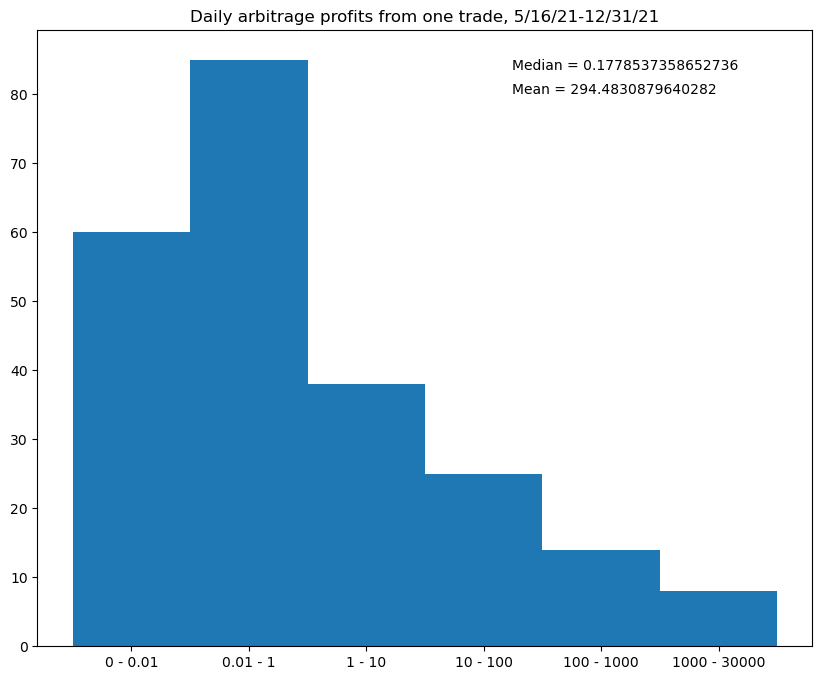

In [27]:
import matplotlib.pyplot as plt

profs = pd.read_excel("Profits.xlsx")['USD']

bins = [0,0.01,1,10, 100, 1000, 30000]

hist, bin_edges = np.histogram(profs,bins) # make the histogram

fig,ax = plt.subplots(figsize = (10,8))
plt.title("Daily arbitrage profits from one trade, 5/16/21-12/31/21")

plt.figtext(0.6, 0.83, f'Median = {np.median(profs)}')
plt.figtext(0.6, 0.8, f'Mean = {np.mean(profs)}')

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1) 

# Set the ticks to the middle of the bars
ax.set_xticks([i for i,j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i],bins[i+1]) for i,j in enumerate(hist)])

plt.show()

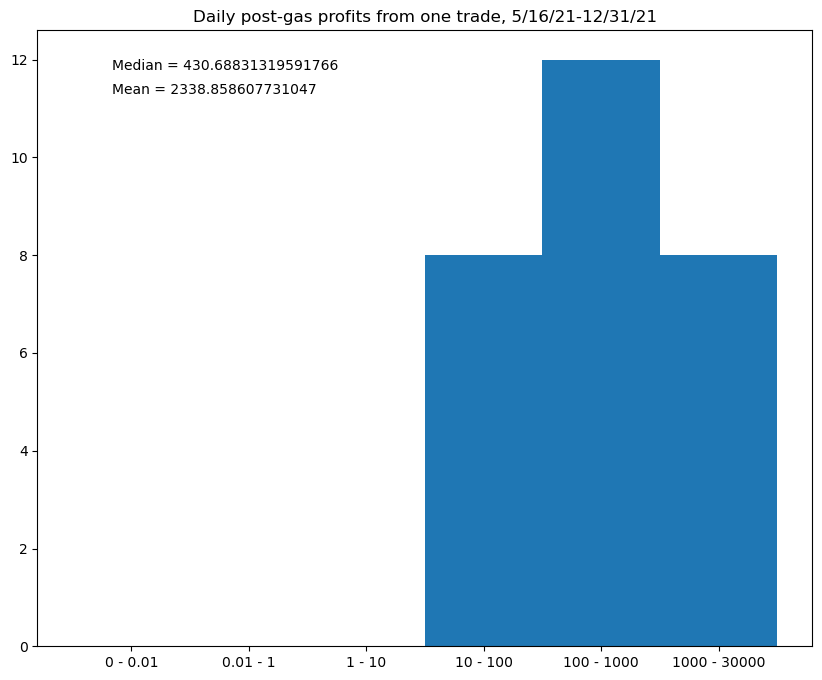

In [3]:
import matplotlib.pyplot as plt

profs = pd.read_excel("Profits.xlsx")['USD']
profsaftergas = []
for elt in profs:
    if elt > 60:
        profsaftergas.append(elt-60)

bins = [0,0.01,1,10, 100, 1000, 30000]

hist, bin_edges = np.histogram(profsaftergas,bins) # make the histogram

fig,ax = plt.subplots(figsize = (10,8))
plt.title("Daily post-gas profits from one trade, 5/16/21-12/31/21")

plt.figtext(0.2, 0.83, f'Median = {np.median(profsaftergas)}')
plt.figtext(0.2, 0.8, f'Mean = {np.mean(profsaftergas)}')

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1) 

# Set the ticks to the middle of the bars
ax.set_xticks([i for i,j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['{} - {}'.format(bins[i],bins[i+1]) for i,j in enumerate(hist)])

plt.show()